In [1]:
import os
import sys
import importlib
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [3]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import data.Datasets
import models.Feedforward
import models.Attention
import utils.train

In [4]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [21]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 244 - 244

batch_size = 256

base_data_path = (join_path('Data\\Split_Data_2'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            )
            # os.path.join(base_data_path, f'KPCA\\Cosine\\reflectance_{split}.pkl')
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)

In [25]:
# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 200

model = models.Feedforward.SimpleFeedforwardModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')

model

SimpleFeedforwardModel(
  (linear1): Linear(in_features=245, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=64, bias=True)
  (linear5): Linear(in_features=64, out_features=32, bias=True)
  (linear6): Linear(in_features=32, out_features=16, bias=True)
  (linear_output): Linear(in_features=16, out_features=1, bias=True)
  (layernorm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (layernorm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (layernorm3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (layernorm4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layernorm5): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (layernorm6): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
)

In [29]:
importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=200,#n_epochs,
    loss_interval=1,
    preexisting_losses=[train_loss, val_loss],
    device=device,
)

Epoch 201	 Train Loss: 0.055785	 Val Loss: 0.1362 	 Avg Error: 1.8556	LR: 3.125e-06	Time: 2.9e+01
Epoch 202	 Train Loss: 0.055559	 Val Loss: 0.13573 	 Avg Error: 1.8524	LR: 3.125e-06	Time: 3e+01
Epoch 203	 Train Loss: 0.05536	 Val Loss: 0.1354 	 Avg Error: 1.8501	LR: 3.125e-06	Time: 2.9e+01
Epoch 204	 Train Loss: 0.055191	 Val Loss: 0.13509 	 Avg Error: 1.848	LR: 3.125e-06	Time: 2.9e+01
Epoch 205	 Train Loss: 0.055019	 Val Loss: 0.13489 	 Avg Error: 1.8466	LR: 3.125e-06	Time: 2.9e+01
Epoch 206	 Train Loss: 0.054872	 Val Loss: 0.13465 	 Avg Error: 1.845	LR: 3.125e-06	Time: 2.9e+01
Epoch 207	 Train Loss: 0.054721	 Val Loss: 0.13437 	 Avg Error: 1.8431	LR: 3.125e-06	Time: 2.9e+01
Epoch 208	 Train Loss: 0.054567	 Val Loss: 0.13416 	 Avg Error: 1.8416	LR: 3.125e-06	Time: 2.9e+01
Epoch 209	 Train Loss: 0.054432	 Val Loss: 0.1339 	 Avg Error: 1.8398	LR: 3.125e-06	Time: 3e+01
Epoch 210	 Train Loss: 0.05429	 Val Loss: 0.13373 	 Avg Error: 1.8387	LR: 3.125e-06	Time: 3.2e+01
Epoch 211	 Train Loss

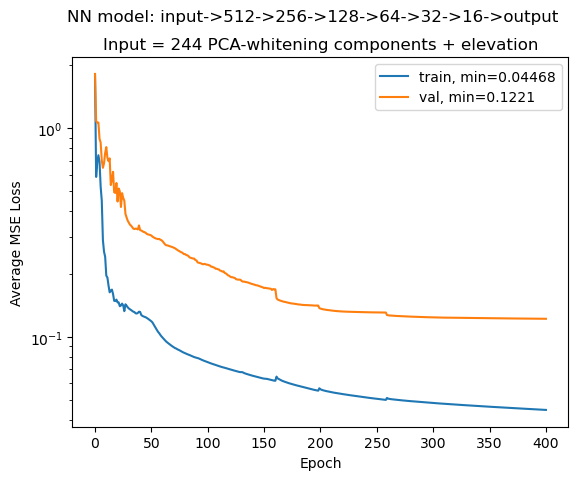

In [30]:
fig, ax = plt.subplots()
fig.suptitle('NN model: input->512->256->128->64->32->16->output')
ax.set_title('Input = 244 PCA-whitening components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)

Epoch 000	 Train Loss: 1.1936	 Val Loss: 1.1876 	 Avg Error: 5.4793	LR: 0.0001	Time: 2.3e+01
Epoch 001	 Train Loss: 1.0002	 Val Loss: 0.99749 	 Avg Error: 5.0217	LR: 0.0001	Time: 2.5e+01
Epoch 002	 Train Loss: 1.0116	 Val Loss: 1.0009 	 Avg Error: 5.0301	LR: 0.0001	Time: 2.4e+01
Epoch 003	 Train Loss: 0.98994	 Val Loss: 1.0777 	 Avg Error: 5.2197	LR: 0.0001	Time: 2.4e+01
Epoch 004	 Train Loss: 1.0087	 Val Loss: 1.0035 	 Avg Error: 5.0368	LR: 0.0001	Time: 2.4e+01
Epoch 005	 Train Loss: 1.0038	 Val Loss: 1.0061 	 Avg Error: 5.0433	LR: 5e-05	Time: 2.5e+01
Epoch 006	 Train Loss: 1.0054	 Val Loss: 1.0032 	 Avg Error: 5.0361	LR: 5e-05	Time: 2.5e+01
Epoch 007	 Train Loss: 1.0028	 Val Loss: 1.0035 	 Avg Error: 5.0367	LR: 5e-05	Time: 2.5e+01
Epoch 008	 Train Loss: 0.99963	 Val Loss: 0.99712 	 Avg Error: 5.0207	LR: 2.5e-05	Time: 2.5e+01
Epoch 009	 Train Loss: 0.9957	 Val Loss: 0.99514 	 Avg Error: 5.0158	LR: 2.5e-05	Time: 2.6e+01
Epoch 010	 Train Loss: 0.9933	 Val Loss: 0.99382 	 Avg Error: 5.01

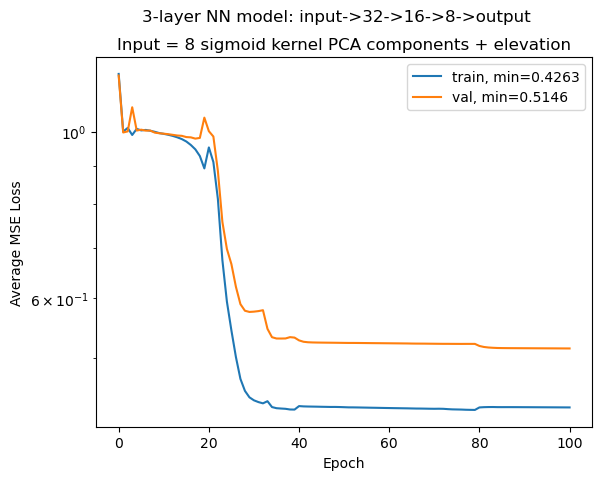

In [6]:
# Make datasets and dataloaders

# setup

importlib.reload(data.Datasets)

omit_components = 244 - 8

batch_size = 256

base_data_path = (join_path('Data\\Split_Data_2'))

train_splits = ['00', '02', '04', '06', '08', '10', '12', '14', '16', '18']
val_splits = ['01', '05', '09', '13', '17']
test_splits = ['03', '07', '11', '15', '19']


# load data

# emit
emit_train_list = []
for split in train_splits:
    emit_train_list.append(
        pickle_load(
            # os.path.join(
                # base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}_list.pkl'
            )
        )
    )
emit_train = np.concatenate(emit_train_list, axis=0)

emit_val_list = []
for split in val_splits:
    emit_val_list.append(
        pickle_load(
            # os.path.join(
                # base_data_path, f'Full_PCA\\reflectance_{split}_pca244.pkl'
            # )
            os.path.join(
                base_data_path, f'KPCA\\Sigmoid\\reflectance_{split}_list.pkl'
            )
        )
    )
emit_val = np.concatenate(emit_val_list, axis=0)

# ecostress
eco_train_list = []
for split in train_splits:
    eco_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_train = np.concatenate(eco_train_list, axis=0)

eco_val_list = []
for split in val_splits:
    eco_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\temp_day_{split}_list.pkl'
            )
        )
    )
eco_val = np.concatenate(eco_val_list, axis=0)

# elevation
elev_train_list = []
for split in train_splits:
    elev_train_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_train = np.concatenate(elev_train_list, axis=0)

elev_val_list = []
for split in val_splits:
    elev_val_list.append(
        pickle_load(
            os.path.join(
                base_data_path, f'List_Data\\elevation_{split}_list.pkl'
            )
        )
    )
elev_val = np.concatenate(elev_val_list, axis=0)


# create datasets and dataloaders

train_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_train,
    omit_components=omit_components,
    ecostress_data=eco_train,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_train,),
    device=device,
)

val_dataset = data.Datasets.EmitEcostressDataset(
    emit_data=emit_val,
    omit_components=omit_components,
    ecostress_data=eco_val,
    ecostress_center=None,
    ecostress_scale=None,
    additional_data=(elev_val,),
    device=device,
)

train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset, batch_size=batch_size, drop_last=True
)


# Make model, optimizer, and loss function
importlib.reload(models.Feedforward)
importlib.reload(models.Attention)

n_epochs = 100

model = models.Feedforward.ToyModel(
    input_dim=train_dataset.input_dim
)

if device == 'cuda':
    model = model.cuda()

optimizer = optim.Adam(
    params=model.parameters(), lr=0.0001, weight_decay=0, fused=True
)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=2
)
# scheduler = None

loss_fn = nn.MSELoss(reduction='sum')


importlib.reload(utils.train)
train_loss, val_loss = utils.train.train(
    model,
    optimizer,
    scheduler,
    loss_fn,
    train_loader,
    val_loader,
    n_epochs=n_epochs,
    loss_interval=1,
    # preexisting_losses=[train_loss, val_loss],
    device=device,
)


fig, ax = plt.subplots()
fig.suptitle('3-layer NN model: input->32->16->8->output')
ax.set_title('Input = 8 sigmoid kernel PCA components + elevation')
ax.semilogy(
    np.arange(len(train_loss)),
    train_loss,
    label=f'train, min={min(train_loss):.4}',
)
ax.semilogy(
    np.arange(len(val_loss)), val_loss, label=f'val, min={min(val_loss):.4}'
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Average MSE Loss')
ax.legend()
plt.show(fig)